In [ ]:
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from torch.utils.data import Dataset, DataLoader

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# Task 1: Digit Image Classifier

In [ ]:
def plot_digits(X, nrows=8, ncols=8):
    fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    ax = ax.flatten()
    _, height, width = X[0].shape
    rndm_idx = np.random.choice(X.shape[0], nrows * ncols)

    for i in range(nrows * ncols):
        image = np.reshape(X[rndm_idx[i]], (height, width))
        ax[i].imshow(image, cmap='gray_r')

# plot loss history
def plot_history(train_history, test_history=None, ylabel=""):
    plt.figure(figsize=(10, 6))

    train_history = np.array(train_history)
    plt.plot(train_history[:, 0], train_history[:, 1], label="Train history")

    if test_history:
        test_history = np.array(test_history)
        plt.plot(test_history[:, 0], test_history[:, 1], label="Test history")

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def evaluate(X_test, y_test):
    # Evaluate the model using the test set
    classifier.eval()
    correct = 0
    eval_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for X, y in zip(X_test, y_test):
            # Unpack batch dimensions
            X = X.unsqueeze(0)
            y = y.unsqueeze(0)
            # Calculate outputs by running images through the network
            y_pred = classifier(X)
            loss = softmax_loss(y_pred, y)
            # The predicted class label is the maximum prediction
            predicted = torch.argmax(y_pred, 1)
            true = torch.argmax(y, 1)
            correct += (predicted == true).sum().item()
            eval_loss += loss

    eval_loss /= X_test.shape[0]

    return eval_loss, correct

## a) Load and Visualize MNIST Dataset: Utilize sklearn’s datasets to load the MNIST digit dataset, where each image is composed of $8 \times 8$ pixels and has grayscale values, and plot some samples to understand what the images look like.

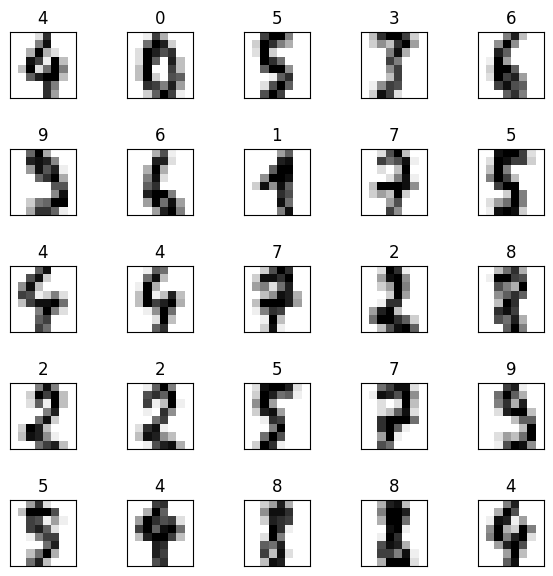

In [ ]:
# Load small MNIST dataset using sklearn.datasets.load_digits.
mnist = load_digits()

X, y = mnist.images, mnist.target


# plot example images from MNIST dataset
fig, ax = plt.subplots(5, 5, figsize=(6, 6))
fig.tight_layout()
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax = ax.flatten()

for i in range(25):
    ax[i].set_title(f"{y[i + 100]}")
    ax[i].imshow(X[i + 100], cmap='gray_r')

### 1. Convert labels to one-hot encodings for classification:

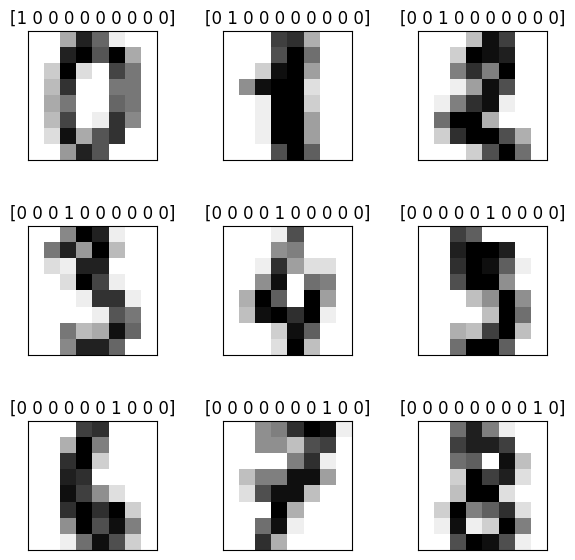

In [ ]:
# Convert y to be one-hot encoded (this is important for classification!)
y = LabelBinarizer().fit_transform(load_digits().target)

# plot example images from MNIST dataset
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
fig.tight_layout()
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax = ax.flatten()

for i in range(9):
    ax[i].set_title(f"{y[i]}")
    ax[i].imshow(X[i], cmap='gray_r')

### 2. Add a channel dimension to input data, as PyTorch expects inputs of the shape [B, C, H, W (, D)] where B is the batch dimension, C the number of channels of the input, H the image height, W the image width, and, for 3D CNNs, D the depth of the image.

In [ ]:
print(f"Shape of X before adding channel dimension: {X.shape}")
# Add channel dimension to X
X = X[:, np.newaxis, ...]

print(f"Shape of X after adding channel dimension:  {X.shape}")

Shape of X before adding channel dimension: (1797, 8, 8)
Shape of X after adding channel dimension:  (1797, 1, 8, 8)


### 3. Split the dataset into training and test sets using sklearn’s train_test_split, ensuring a reasonable ratio and shuffling the data.

In [ ]:
# Split up the dataset into train and test sets with a reasonable amount of test samples.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

print("X_train: {} samples ({}), {} x {} x {}".format(X_train.shape[0], X_train.dtype, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
print("X_test:  {}  samples ({}), {} x {} x {}".format(X_test.shape[0], X_test.dtype, X_test.shape[1], X_test.shape[2], X_test.shape[3]))

X_train: 1437 samples (float64), 1 x 8 x 8
X_test:  360  samples (float64), 1 x 8 x 8


### 4. Convert the data for PyTorch: Transform the numpy arrays into PyTorch tensors, preparing them for model input.

X_train: 1437 samples (torch.float32), 1 x 8 x 8
X_test:  360  samples (torch.float32), 1 x 8 x 8


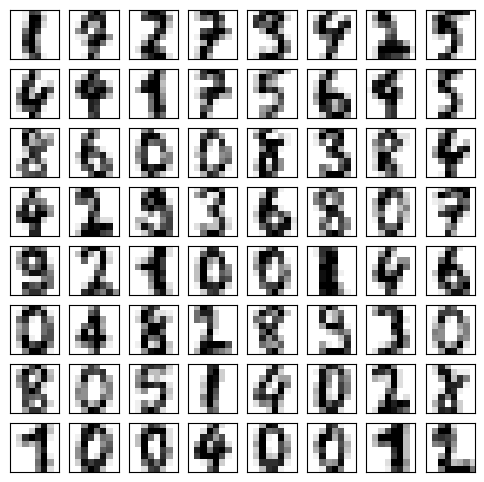

In [ ]:
# Convert numpy arrays to torch tensors
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test  = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test  = torch.from_numpy(y_test.astype(np.float32))

print("X_train: {} samples ({}), {} x {} x {}".format(X_train.shape[0], X_train.dtype, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
print("X_test:  {}  samples ({}), {} x {} x {}".format(X_test.shape[0], X_test.dtype, X_test.shape[1], X_test.shape[2], X_test.shape[3]))

# Plot some sample images
plot_digits(X)

## c) Build the CNN model architecture using PyTorch:
1. Create a CNN class inheriting from nn.Module.
2. Define the architecture considering parameters like in_channels, n_conv, n_filters, n_-
classes, and kernel_size. For the convolutional layers choose an appropriate border padding
mode that preserves the feature maps’ shape dimensions during feature extraction.
3. Use ReLU activations for intermediate layers and the softmax activation for the output layer. The
softmax function $z(x_i)$ is defined as
<center>$z(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$

  for each element $x_i$ in the input vector. In multi-class classification, softmax is used at the output layer because it transforms the outputs into probability distributions. Each output value represents the probability that the input belongs to one of the classes. This is particularly useful for classification tasks like digit recognition, where each class (digit) is mutually exclusive.

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, n_conv=8, n_filters=128, n_classes=10, kernel_size=(3, 3)):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, n_conv, kernel_size=kernel_size, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_conv, 2 * n_conv, kernel_size=kernel_size, padding=2)
        self.fc1 = nn.Linear(2 * n_conv * kernel_size[0] * kernel_size[1], n_filters)
        self.fc2 = nn.Linear(n_filters, n_filters // 2)
        self.fc3 = nn.Linear(n_filters // 2, n_classes)

        self.n_conv = n_conv

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions (except batch)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1) # As we are classifying multiple classes we use softmax

        return x

    # Count trainable weights
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def show_shapes(self, x):
      print(f"Shape before convolution: {x.shape}")
      conv1 = self.conv1(x)
      pool1 = self.pool(F.relu(conv1))
      conv2 = self.conv2(pool1)
      pool2 = self.pool(F.relu(conv2))

      conv1 = conv1.detach().numpy()
      conv2 = conv2.detach().numpy()
      pool1 = pool1.detach().numpy()
      pool2 = pool2.detach().numpy()
      print(f"Shape after first convolution and pooling: {conv1.shape}")
      print(f"Shape after first pooling: {pool1.shape}")
      print(f"Shape after second convolution and pooling: {conv2.shape}")
      print(f"Shape after second pooling: {pool2.shape}")

    def visualize_conv(self, x):
      conv1 = self.conv1(x)
      pool1 = self.pool(F.relu(conv1))
      conv2 = self.conv2(pool1)
      pool2 = self.pool(F.relu(conv2))

      conv1 = conv1.detach().numpy()
      conv2 = conv2.detach().numpy()
      pool1 = pool1.detach().numpy()
      pool2 = pool2.detach().numpy()

      conv1 = np.squeeze(conv1)
      conv2 = np.squeeze(conv2)
      pool1 = np.squeeze(pool1)
      pool2 = np.squeeze(pool2)

      fig = plt.figure(figsize=(1, 1))
      plt.imshow(x[0, 0], cmap='gray_r')
      plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
      plt.title("Input image")

      fig, ax = plt.subplots(nrows=4, ncols=self.n_conv, figsize=(16, 4))
      #fig.tight_layout()
      plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

      for i in range(self.n_conv):
        ax[0, i].imshow(conv1[i], cmap='gray_r')
        ax[1, i].imshow(pool1[i], cmap='gray_r')
        ax[2, i].imshow(conv2[i], cmap='gray_r')
        ax[3, i].imshow(pool2[i], cmap='gray_r')




## e) Define hyperparameters for training. Therefore, set the number of epochs to train, the learning rate, and other relevant parameters, such as the number of convolutional filters and the number of hidden units. (There is not one correct solution. You can try out different parameters and see what the outcome of your training is.)

In [ ]:
# Define hyperparameters
n_epochs = 2000
n_classes = 10
n_conv = 16
n_filters = 184
learning_rate = 5e-1

## f) Initialize and analyze the model architecture: Print the number of trainable parameters, choose an optimizer like Stocahstic Gradient Descent (SGD) that accepts both the learning rate and model parameters, and define the loss function (cross entropy loss). Check initial loss before training and evaluate the model on the test set using the evaluate(...) function of the CNN.

In [ ]:
# Define CNN architecture
classifier = CNN(n_conv=n_conv, n_filters=n_filters)
print(classifier)
print()
print("# trainable weights: {}".format(classifier.count_parameters()))
print()

# Setup optimizer and define loss function
softmax_loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate) # , momentum=momentum)

# Check initial loss. As we expect a diffuse probability of 0.1 for each class (since there are 10 classes),
# and Softmax loss is the negative log probability of the correct class so: -ln(0.1) = 2.302
print(f"Initial accuracy: {1/10} | Initial lr: {learning_rate} | Initial softmax loss: {-np.log(1/10):.3f}")
print()

# Evaluate the classification model on testset
evaluate(X_test, y_test)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=288, out_features=184, bias=True)
  (fc2): Linear(in_features=184, out_features=92, bias=True)
  (fc3): Linear(in_features=92, out_features=10, bias=True)
)

# trainable weights: 75926

Initial accuracy: 0.1 | Initial lr: 0.5 | Initial softmax loss: 2.303



(tensor(2.3035), 47)

## g) Training Process: Implement the loop over n epochs. For each epoch:
1. Zero the parameter gradients.
2. Forward pass the training images to calculate predictions.
3. Compute loss between prediction y_pred and y_train.
4. Perform a backward pass.
5. Update network parameters.
6. Evaluate on the test set periodically, log and track the training and test losses.

In [ ]:
# Train the model using the training set
classifier.train()
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(0, n_epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    y_pred = classifier(X_train)
    # calculate loss
    loss = softmax_loss(y_train, y_pred)

    # Backward pass
    loss.backward()
    # Optimize
    optimizer.step()

    # Track and log losses
    train_loss_history.append((epoch, loss.item()))
    if (epoch + 1) % 10 == 0:
        test_loss, correct = evaluate(X_test, y_test)
        test_loss_history.append((epoch, test_loss.item()))
        test_accuracy = 100 * correct / X_test.shape[0]
        test_accuracy_history.append((epoch, test_accuracy))
        print(f'Epoch: {epoch + 1:4} / {n_epochs} | train loss: {loss:.3f} | Test loss: {test_loss:.3f} Test accuracy: {test_accuracy:.2f} %', end='\r')

print(), print()
# Evaluate the classification model on testset
loss, correct = evaluate(X_test, y_test)
print(f'Test loss: {loss:.3f} Test accuracy: {100 * correct / X_test.shape[0]} %')

Epoch: 2000 / 2000 | train loss: 1.566 | Test loss: 1.559 Test accuracy: 90.28 %

Test loss: 1.559 Test accuracy: 90.27777777777777 %


Shape before convolution: torch.Size([1, 1, 8, 8])
Shape after first convolution and pooling: (1, 16, 10, 10)
Shape after first pooling: (1, 16, 5, 5)
Shape after second convolution and pooling: (1, 32, 7, 7)
Shape after second pooling: (1, 32, 3, 3)


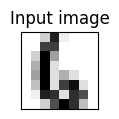

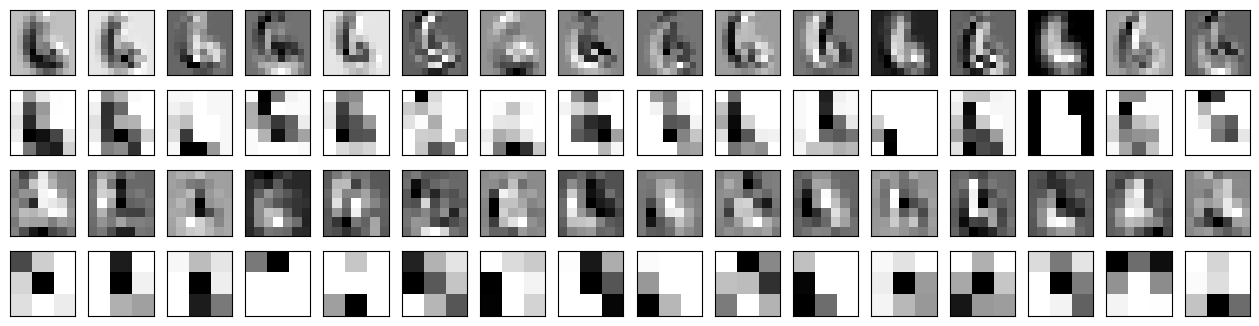

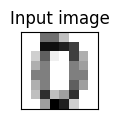

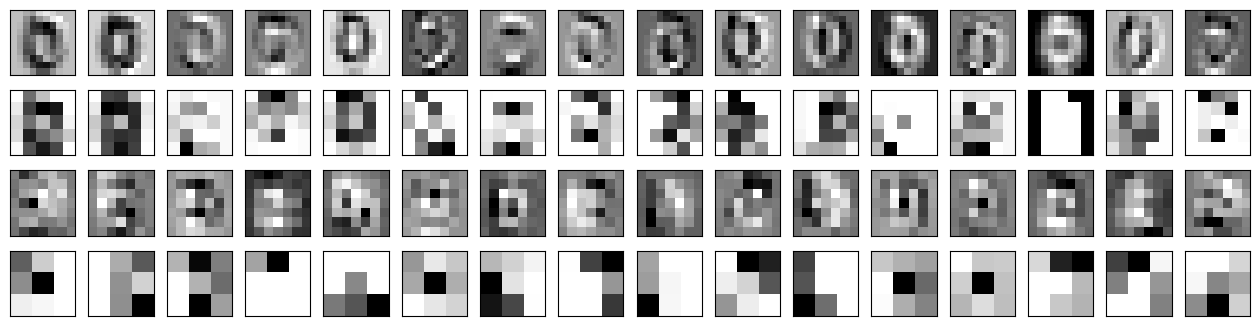

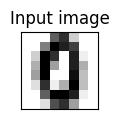

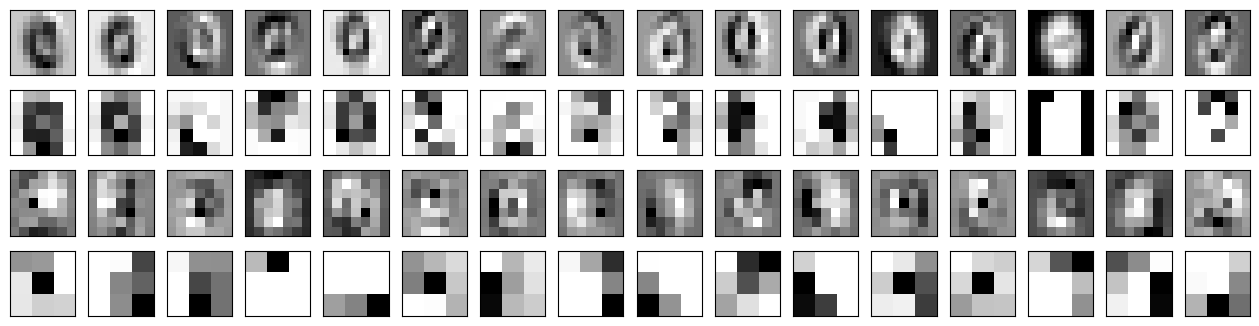

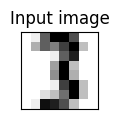

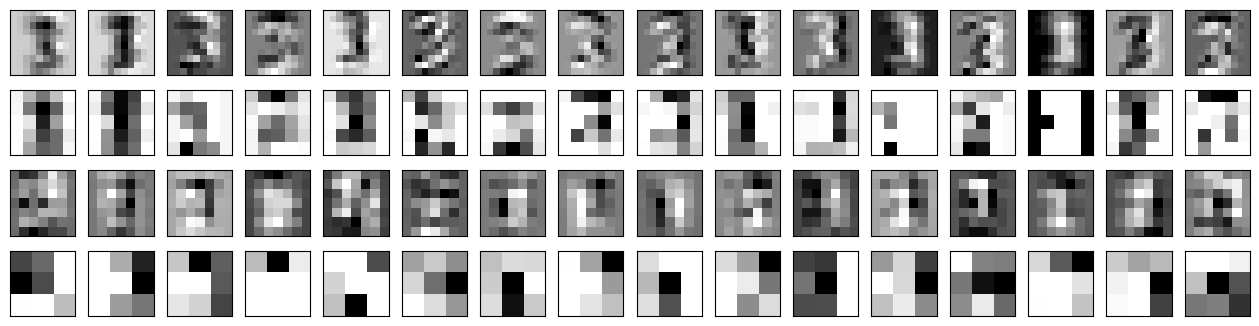

In [ ]:
classifier.show_shapes(X_train[0].unsqueeze(0))

classifier.visualize_conv(X_train[0].unsqueeze(0))
classifier.visualize_conv(X_train[1].unsqueeze(0))
classifier.visualize_conv(X_train[2].unsqueeze(0))
classifier.visualize_conv(X_train[3].unsqueeze(0))

## g) Plot results of the training and test loss history over epochs and plot the accuracy on the test set over epochs. If your training is not successful try to find possible solutions. Maybe your network size is to small. Try changing the number of filters in each convolutional layer or the number of convolutional layers.

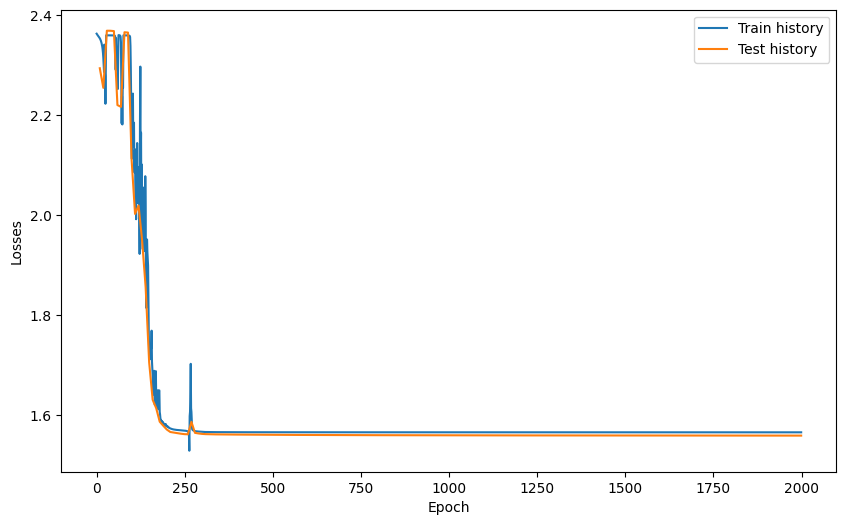

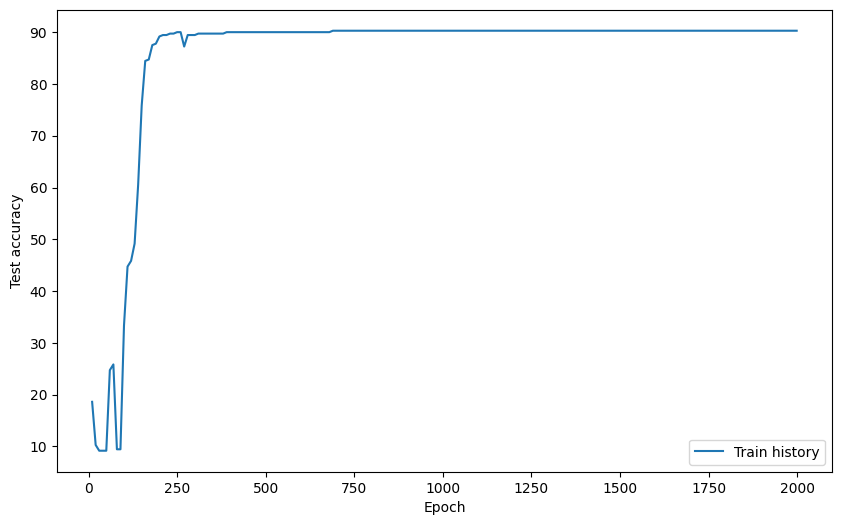

In [ ]:
# Plot loss history over epochs

plot_history(train_loss_history, test_loss_history, ylabel="Losses")
plot_history(test_accuracy_history, ylabel="Test accuracy")